# XGBoost with SHAP

### Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import GridSearchCV

import time
import sys
import gc
import pickle
import os
import platform
import shap

### Load & Preprocess Data

In [2]:
df = pd.read_pickle(os.path.abspath("../dat")+'/feature_3.pkl')
test = pd.read_csv(os.path.abspath("../dat")+'/test.csv', encoding='cp949')
df

,month,item_cnt_month_lag_1,item_cnt_week6_lag_1,item_cnt_month_lag_4,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_week5_lag_1,week5_avg_item_cnt_lag_1,month_avg_item_cnt_lag_4,week4_cat_avg_item_cnt_lag_1,week5_avg_item_cnt_lag_2,week5_avg_item_cnt_lag_4,item_cnt_week3_lag_2,item_cnt_week4_lag_1,week3_avg_item_cnt_lag_3,week1_avg_item_cnt_lag_3,month_avg_item_cnt_lag_1,week4_avg_item_cnt_lag_3,week5_cat_avg_item_cnt_lag_1,category_중고등학습서,week1_avg_item_cnt_lag_1,week1_avg_item_cnt_lag_2,item_cnt_week4_lag_2,category_초등학습서,week6_avg_item_cnt_lag_2,month_cat_avg_item_cnt_lag_1,item_cnt_week1_lag_3,category_수험서 자격증,week1_cat_avg_item_cnt_lag_1,week1_avg_item_cnt_lag_4,week3_cat_avg_item_cnt_lag_1,item_cnt_month
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,1.0
1,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.120691,0.0,0.0,0.385694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.419635,0.0,1.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,1.0
3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,1.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154598,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0
154599,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0
154600,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0
154601,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0.0,0.000000,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154603 entries, 0 to 154602
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   month                         154603 non-null  int64  
 1   item_cnt_month_lag_1          154603 non-null  float64
 2   item_cnt_week6_lag_1          154603 non-null  float64
 3   item_cnt_month_lag_4          154603 non-null  float64
 4   item_cnt_month_lag_2          154603 non-null  float64
 5   item_cnt_month_lag_3          154603 non-null  float64
 6   item_cnt_week5_lag_1          154603 non-null  float64
 7   week5_avg_item_cnt_lag_1      154603 non-null  float64
 8   month_avg_item_cnt_lag_4      154603 non-null  float64
 9   week4_cat_avg_item_cnt_lag_1  154603 non-null  float64
 10  week5_avg_item_cnt_lag_2      154603 non-null  float64
 11  week5_avg_item_cnt_lag_4      154603 non-null  float64
 12  item_cnt_week3_lag_2          154603 non-nul

### Train & Evaluate the Model

1. 5~7월 데이터를 학습하여 첫번째 모형 생성
2. 8~10월 데이터에 첫번째 모형을 적용해서 얻은 예측값을 새로운 feature로 추가
3. 추가된 feature + 원래 feature로 8~10월 데이터를 학습하여 두번째 모형 생성
4. 두번째 모형에 대해 SHAP을 적용하여 feature 선택
5. 선택된 feature를 사용하여 재학습, 최종 모형 생성 

#### 첫번째 학습

데이터 준비

In [4]:
X_train = df[df.month < 8].drop(['item_cnt_month'], axis=1)
y_train = df[df.month < 8]['item_cnt_month']
X_valid = df[df.month == 11].drop(['item_cnt_month'], axis=1)
y_valid = df[df.month == 11]['item_cnt_month']
X_test = df[df.month == 12].drop(['item_cnt_month'], axis=1)

모델링

In [5]:
model = XGBRegressor(colsample_bytree = 0.7, 
                     learning_rate= 0.03, 
                     max_depth= 5, 
                     min_child_weight= 4, 
                     n_estimators= 500, 
                     nthread= 4, 
                     objective= 'reg:linear', 
                     silent= 1, 
                     subsample= 0.7, 
                     random_state=0)
model.fit(
    X_train, 
    y_train, 
    eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True,
    early_stopping_rounds = 10)

[10:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2.98200	validation_1-rmse:3.28512
[1]	validation_0-rmse:2.93840	validation_1-rmse:3.24297
[2]	validation_0-rmse:2.89861	validation_1-rmse:3.20780
[3]	validation_0-rmse:2.85747	validation_1-rmse:3.16840
[4]	validation_0-rmse:2.82113	validation_1-rmse:3.13568
[5]	validation_0-rmse:2.78293	validation_1-rmse:3.09895
[6]	validation_0-rmse:2.74839	validation_1-rmse:3.06881
[7]	validation_0-rmse:2.71479	validation_1-rmse

[134]	validation_0-rmse:1.96412	validation_1-rmse:2.30757
[135]	validation_0-rmse:1.96365	validation_1-rmse:2.30731
[136]	validation_0-rmse:1.96313	validation_1-rmse:2.30709
[137]	validation_0-rmse:1.96271	validation_1-rmse:2.30692
[138]	validation_0-rmse:1.96221	validation_1-rmse:2.30678
[139]	validation_0-rmse:1.96179	validation_1-rmse:2.30607
[140]	validation_0-rmse:1.96114	validation_1-rmse:2.30593
[141]	validation_0-rmse:1.96076	validation_1-rmse:2.30610
[142]	validation_0-rmse:1.96041	validation_1-rmse:2.30615
[143]	validation_0-rmse:1.96006	validation_1-rmse:2.30598
[144]	validation_0-rmse:1.95976	validation_1-rmse:2.30604
[145]	validation_0-rmse:1.95932	validation_1-rmse:2.30614
[146]	validation_0-rmse:1.95887	validation_1-rmse:2.30643
[147]	validation_0-rmse:1.95866	validation_1-rmse:2.30627
[148]	validation_0-rmse:1.95819	validation_1-rmse:2.30639
[149]	validation_0-rmse:1.95761	validation_1-rmse:2.30620
[150]	validation_0-rmse:1.95718	validation_1-rmse:2.30644


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

첫번째 모형의 예측값을 새로운 feature로 추가

In [6]:
df["addvalue"] = model.predict(df.drop(['item_cnt_month'], axis=1))

#### 두번째 학습

데이터 준비

In [7]:
X_train = df.query("month>=8 and month<=10").drop(['item_cnt_month'], axis=1)
y_train = df.query("month>=8 and month<=10")['item_cnt_month']
X_valid = df[df.month == 11].drop(['item_cnt_month'], axis=1)
y_valid = df[df.month == 11]['item_cnt_month']
X_test = df[df.month == 12].drop(['item_cnt_month'], axis=1)

모델링

In [8]:
model = XGBRegressor(colsample_bytree = 0.7, 
                     learning_rate= 0.03, 
                     max_depth= 5, 
                     min_child_weight= 4, 
                     n_estimators= 500, 
                     nthread= 4, 
                     objective= 'reg:linear', 
                     silent= 1, 
                     subsample= 0.7, 
                     random_state=0)
model.fit(
    X_train, 
    y_train, 
    eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True,
    early_stopping_rounds = 10)

[10:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2.90862	validation_1-rmse:3.28855
[1]	validation_0-rmse:2.86189	validation_1-rmse:3.24821
[2]	validation_0-rmse:2.81693	validation_1-rmse:3.21028
[3]	validation_0-rmse:2.77495	validation_1-rmse:3.17266
[4]	validation_0-rmse:2.73394	validation_1-rmse:3.13707
[5]	validation_0-rmse:2.69392	validation_1-rmse:3.10454
[6]	validation_0-rmse:2.65626	validation_1-rmse:3.07203
[7]	validation_0-rmse:2.62052	validation_1-rmse

[134]	validation_0-rmse:1.88900	validation_1-rmse:2.34206
[135]	validation_0-rmse:1.88859	validation_1-rmse:2.34098
[136]	validation_0-rmse:1.88825	validation_1-rmse:2.34082
[137]	validation_0-rmse:1.88781	validation_1-rmse:2.34067
[138]	validation_0-rmse:1.88718	validation_1-rmse:2.34089
[139]	validation_0-rmse:1.88675	validation_1-rmse:2.34064
[140]	validation_0-rmse:1.88621	validation_1-rmse:2.34053
[141]	validation_0-rmse:1.88583	validation_1-rmse:2.33997
[142]	validation_0-rmse:1.88530	validation_1-rmse:2.34005
[143]	validation_0-rmse:1.88482	validation_1-rmse:2.33989
[144]	validation_0-rmse:1.88448	validation_1-rmse:2.33982
[145]	validation_0-rmse:1.88406	validation_1-rmse:2.33967
[146]	validation_0-rmse:1.88356	validation_1-rmse:2.33984
[147]	validation_0-rmse:1.88316	validation_1-rmse:2.34020
[148]	validation_0-rmse:1.88263	validation_1-rmse:2.33983
[149]	validation_0-rmse:1.88213	validation_1-rmse:2.33960
[150]	validation_0-rmse:1.88149	validation_1-rmse:2.33975
[151]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### 세번째 학습

SHAP를 이용한 feature 선택

Glyph 52488 missing from current font.
Glyph 46321 missing from current font.
Glyph 54617 missing from current font.
Glyph 49845 missing from current font.
Glyph 49436 missing from current font.
Glyph 51473 missing from current font.
Glyph 44256 missing from current font.
Glyph 52488 missing from current font.
Glyph 46321 missing from current font.
Glyph 54617 missing from current font.
Glyph 49845 missing from current font.
Glyph 49436 missing from current font.
Glyph 51473 missing from current font.
Glyph 44256 missing from current font.


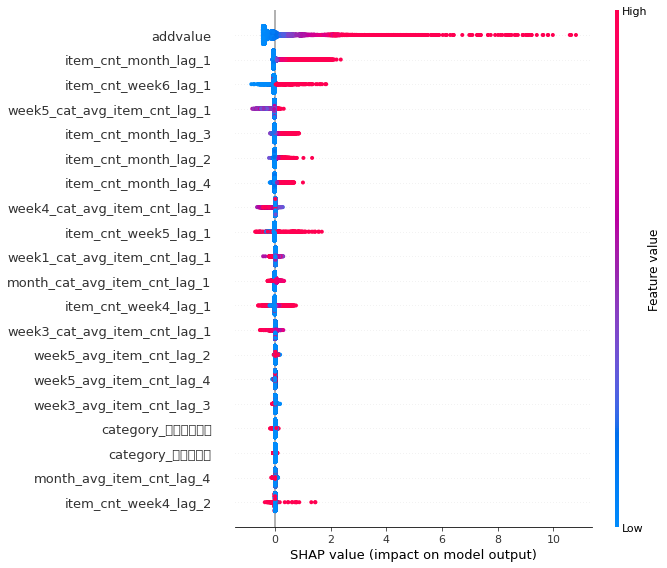

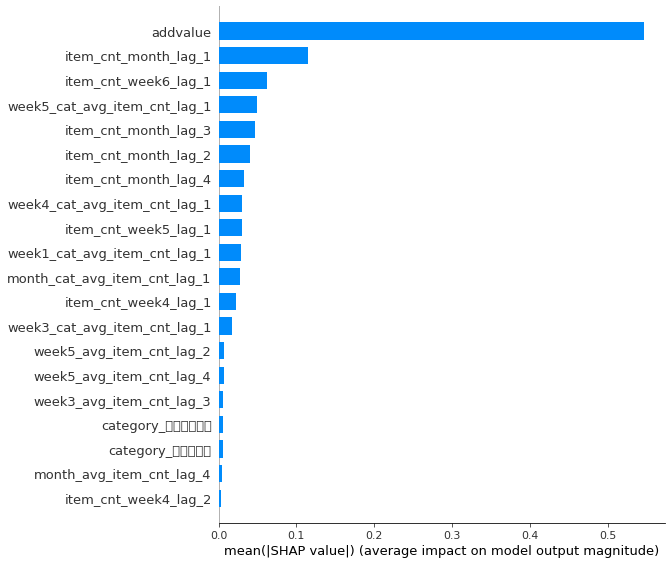

,column_name,shap_importance
31,addvalue,0.546079
1,item_cnt_month_lag_1,0.114383
2,item_cnt_week6_lag_1,0.0619172
18,week5_cat_avg_item_cnt_lag_1,0.0492035
5,item_cnt_month_lag_3,0.0472185
4,item_cnt_month_lag_2,0.0398409
3,item_cnt_month_lag_4,0.0326074
9,week4_cat_avg_item_cnt_lag_1,0.0303404
6,item_cnt_week5_lag_1,0.0300832
28,week1_cat_avg_item_cnt_lag_1,0.028163


In [9]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [10]:
features_selected = importance_df.iloc[:30].column_name
#features_selected = importance_df.query('shap_importance > 0').column_name
X_train = X_train[features_selected]
X_valid = X_valid[features_selected]
X_test = X_test[features_selected]

중요 feature에 대해 상호작용 feature를 생성

In [11]:
features_interact = importance_df.iloc[:3].column_name
for e, (x, y) in enumerate(combinations(features_interact,2)):
    X_train[f'inter_{e}*'] = X_train[x] * X_train[y]
    X_valid[f'inter_{e}*'] = X_valid[x] * X_valid[y]
    X_test[f'inter_{e}*'] = X_test[x] * X_test[y]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


모델링

In [12]:
model = XGBRegressor(colsample_bytree = 0.7, 
                     learning_rate= 0.03, 
                     max_depth= 5, 
                     min_child_weight= 4, 
                     n_estimators= 500, 
                     nthread= 4, 
                     objective= 'reg:linear', 
                     silent= 1, 
                     subsample= 0.7, 
                     random_state=0)
model.fit(
    X_train, 
    y_train, 
    eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True,
    early_stopping_rounds = 10)

[10:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2.90858	validation_1-rmse:3.28864
[1]	validation_0-rmse:2.86203	validation_1-rmse:3.24771
[2]	validation_0-rmse:2.81703	validation_1-rmse:3.20863
[3]	validation_0-rmse:2.77428	validation_1-rmse:3.17200
[4]	validation_0-rmse:2.73351	validation_1-rmse:3.13689
[5]	validation_0-rmse:2.69379	validation_1-rmse:3.10195
[6]	validation_0-rmse:2.65606	validation_1-rmse:3.06959
[7]	validation_0-rmse:2.62018	validation_1-rmse

[134]	validation_0-rmse:1.88551	validation_1-rmse:2.34114
[135]	validation_0-rmse:1.88503	validation_1-rmse:2.34087
[136]	validation_0-rmse:1.88460	validation_1-rmse:2.34070
[137]	validation_0-rmse:1.88426	validation_1-rmse:2.34056
[138]	validation_0-rmse:1.88375	validation_1-rmse:2.34057
[139]	validation_0-rmse:1.88341	validation_1-rmse:2.34056
[140]	validation_0-rmse:1.88289	validation_1-rmse:2.34036
[141]	validation_0-rmse:1.88220	validation_1-rmse:2.33987
[142]	validation_0-rmse:1.88171	validation_1-rmse:2.33969
[143]	validation_0-rmse:1.88125	validation_1-rmse:2.33951
[144]	validation_0-rmse:1.88072	validation_1-rmse:2.33947
[145]	validation_0-rmse:1.88034	validation_1-rmse:2.33959
[146]	validation_0-rmse:1.88003	validation_1-rmse:2.33984
[147]	validation_0-rmse:1.87973	validation_1-rmse:2.33964
[148]	validation_0-rmse:1.87948	validation_1-rmse:2.33966
[149]	validation_0-rmse:1.87881	validation_1-rmse:2.33959
[150]	validation_0-rmse:1.87820	validation_1-rmse:2.33962
[151]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Make Submissions

In [13]:
submission = pd.DataFrame({
    "item_id": test.item_id, 
    "item_cnt_month": model.predict(X_test).clip(0, 20)
})

submission.to_csv('../dat/submissions/xgb_for_ensemble.csv', index=False)

# End